In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bmxobs
import os

# BMX Data

BMX data is coming from 8 channels enumerated 1-8. 1-4 correspond to N,E,S,W dishes in the N-S E-polarization mode. Channels 5-8 are the same in the E-W E-polarization mode. We cross-correlate every combination from the same polarization state.

BMX data is further divided into "cuts". Cut 0 is the full frequency data and cut 1 is the zoomed-in version around the galactic 21cm emission.

Each data combination is referred by the channels (lower number first) and the cut.
Therefore:
 * 110 is the N(1) auto-correlated with itself (1-1) and for the full frequency data (0)
 * 241 is the E(2) cross-correalted with W(4) for the zoom around the 21cm region.
 
 To avoid excessive loading times (or out-of memory conditions) we can specify which data to load.

In [2]:
# just load the 110,240 and 111 channel combinations
D = bmxobs.BMXObs('230924_2200', channels='110,240,111,241')
# there are some flags
print ("Flags:",D.meta)

Flags: {'passage', 'no_diode', 'galactic21_cut', 'have_temperatures'}


In [3]:
# we access data by their ID. The return is an array which has time-axis as first coordinate and frequency axis as second.
D[240].shape

(102998, 2048)

In [4]:
# Time coordinates are in MJD or right-ascension.
print (D.ra.shape, D.mjd.shape, D.ra.shape[0] == D[240].shape[0])
# other useful precalcualted coordinates are D.dec and galactic coordinated D.lgal, D.bgal

(102998,) (102998,) True


In [5]:
# frequency coordinates are by the cut number
D.freq[0].shape, D.freq[1].shape, D[110].shape[1] == D.freq[0].shape[0], D[111].shape[1] == D.freq[1].shape[0]

((2048,), (209,), True, True)

In [6]:
# Frequency ranges are linear:
for e,fl in enumerate(D.freq):
    print (f"Cut {e} has frequencies between {fl[0]:.3f}MHz and {fl[-1]:.3f}MHz in steps of {fl[1]-fl[0]:.3f}MHz.")

Cut 0 has frequencies between 1100.134MHz and 1649.866MHz in steps of 0.269MHz.
Cut 1 has frequencies between 1419.008MHz and 1422.500MHz in steps of 0.017MHz.


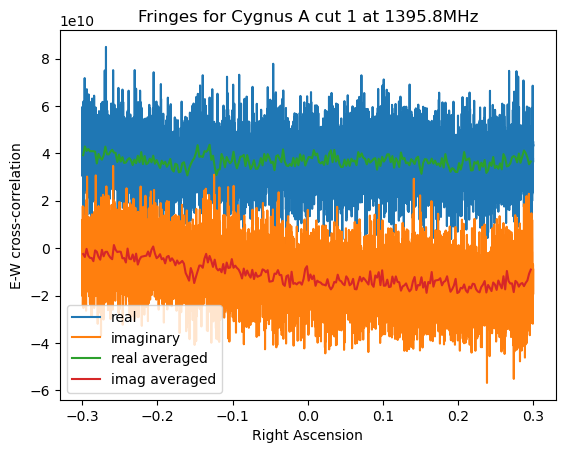

In [17]:
# we can now try to plot some fringes
def avgdata(data,fact):
    N=len(data)
    return data[:(N//fact)*fact].reshape((-1,fact)).mean(axis=1)
ra_center = 0 #radians
freq_bin = 1101
racut = np.where(np.abs(D.ra-ra_center)<0.3)
ra = D.ra[racut]
sig = D[240][racut,freq_bin][0]
plt.plot(ra,np.real(sig),label='real')
plt.plot(ra,np.imag(sig),label='imaginary')
plt.plot(avgdata(ra,32),avgdata(np.real(sig),32),label='real averaged')
plt.plot(avgdata(ra,32),avgdata(np.imag(sig),32),label='imag averaged')
plt.xlabel('Right Ascension')
plt.ylabel('E-W cross-correlation')
plt.title(f'Timesteam from cut 1 at {D.freq[0][freq_bin]:.1f}MHz')
plt.legend()


[('fgpa', '>f4', (4,)), ('adc', '>f4', (4,)), ('frontend', '>f4', (4,))]


Text(0, 0.5, 'Temperature in K for 4 ADC frontends')

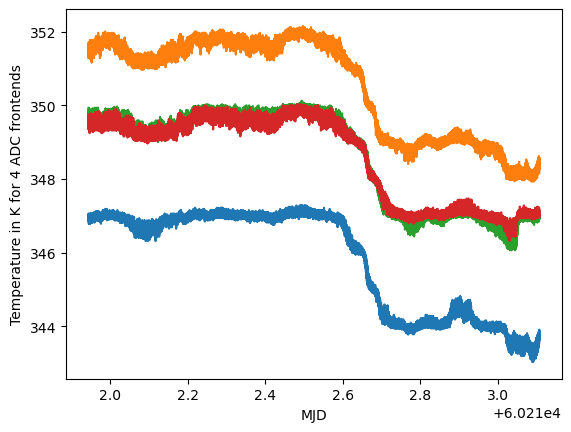

In [8]:
# We also record the ADC temperatures
print(D.temp.dtype)
plt.plot(D.mjd,D.temp['adc'])
plt.xlabel('MJD')
plt.ylabel('Temperature in K for 4 ADC frontends')

In [9]:
# Satellites
print ("10 satellist with closest transits by nominal zenith.")
for name, maxalt in zip(D.sat_id[:10], D.sat_maxalt):
    print (f'Satellite {name} reaches max altitude of {maxalt/np.pi*180:.1f} degrees.')

10 satellist with closest transits by nominal zenith.
Satellite COSMOS_2475_(743) reaches max altitude of 89.8 degrees.
Satellite COSMOS_2522_(752) reaches max altitude of 89.7 degrees.
Satellite COSMOS_2569_(703K) reaches max altitude of 89.7 degrees.
Satellite GPS_BIIRM-4_(PRN_15) reaches max altitude of 89.5 degrees.
Satellite BEIDOU-3_M11_(C25) reaches max altitude of 89.2 degrees.
Satellite GSAT0101_(PRN_E11) reaches max altitude of 89.0 degrees.
Satellite GPS_BIII-4__(PRN_14) reaches max altitude of 88.9 degrees.
Satellite BEIDOU-3_M13_(C32) reaches max altitude of 87.6 degrees.
Satellite GPS_BIIF-11_(PRN_10) reaches max altitude of 87.5 degrees.
Satellite GSAT0210_(PRN_E01) reaches max altitude of 87.4 degrees.


Text(0, 0.5, 'N-S')

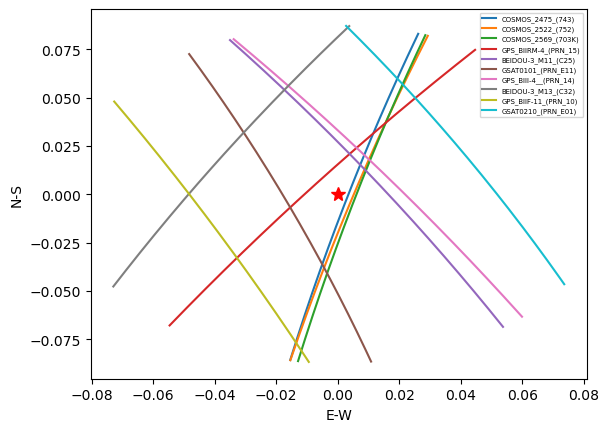

In [10]:
#Let's plot some satellite trracks:
for si, sname in enumerate(D.sat_id[:10]):
    wh = np.where(D.sat[si]['alt']>85/180*np.pi) # pick when above 85 degrees
    alt = D.sat[si]['alt'][wh]
    az = D.sat[si]['az'][wh]
    # let's plot something resembling a track
    plt.plot(np.cos(alt)*np.sin(az),np.cos(alt)*np.cos(az), label=sname)
plt.plot(0,0,'r*',markersize=10)
plt.legend(fontsize=5)
plt.xlabel('E-W')
plt.ylabel('N-S')


Text(0.5, 1.0, 'Log10 power over the passage of the satellite')

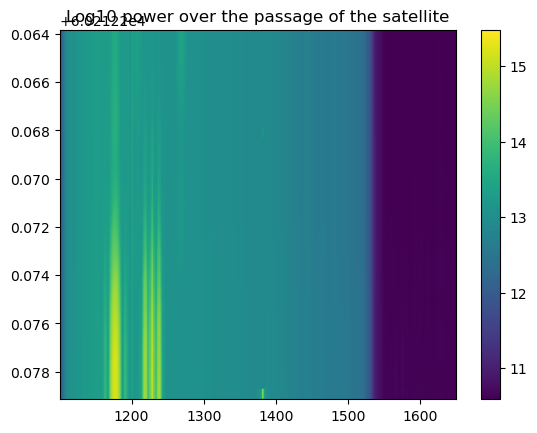

In [11]:
# let's see the signal it makes
plt.imshow(np.log10(D[110][wh[0],:]),extent=(D.freq[0][0], D.freq[0][-1],D.mjd[wh[0][-1]], D.mjd[wh[0][0]]),aspect='auto')
plt.colorbar()
plt.title('Log10 power over the passage of the satellite')